In [1]:
from ultralytics import YOLO
import supervision as sv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import mediapipe as mp
import numpy as np
import os
import random
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from IPython.display import clear_output
import gc
import time
from tqdm import tqdm
from torch.cuda import memory_allocated, empty_cache

## 과일 class_id 확인(생략 가능)

In [3]:
# 과일 class_id 확인
# model = YOLO('yolov8m.pt')
# yolo_result = model('../tmp_data/train_data/nothing_0.jpg', agnostic_nms=True)[0]
# detections = sv.Detections.from_yolov8(yolo_result)
# print(detections.class_id)
# print(model.model.names[49])

## 스켈레톤 추론 함수

In [2]:
mp_pose = mp.solutions.pose
attention_dot = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

draw_line = [[11, 12], [11, 23], [12, 24], [23, 24],
             [11, 13], [13, 15], [15, 17], [17, 19], [15, 21],
             [12, 14], [14, 16], [16, 18], [18, 20], [16, 22]]

box_annotator = sv.BoxAnnotator(
        thickness=2,
        text_thickness=2,
        text_scale=1
    )
 
def show_skeleton(video_path , interval, attention_dot, draw_line):
    model = YOLO('../checkpoint/yolo_pt/best.pt')
    
    xy_list_list, xy_list_list_flip = [], []
    cv2.destroyAllWindows()
    pose = mp_pose.Pose(static_image_mode = True, model_complexity = 1, enable_segmentation = False, min_detection_confidence = 0.3)
    cap = cv2.VideoCapture(video_path)
    
    if cap.isOpened():
        cnt = 0
        while True:
            ret, img = cap.read()
            if cnt == interval and ret == True:
                cnt = 0
                xy_list, xy_list_flip = [], []
                img = cv2.resize(img, (640,  640))
                img = cv2.flip(img, 0) # 상하 반전
                img = cv2.flip(img, 1) # 좌우 반전
                yolo_result = model(img, agnostic_nms=True)[0]
                detections = sv.Detections.from_yolov8(yolo_result)
                
                # selected_classes = [0, 1, 2, 3, 4] # 46: banana, 47 : apple, 49: orange 
                # detections = detections[np.isin(detections.class_id, selected_classes)]

                labels = [f"{model.model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
                
                results = pose.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                
                if not results.pose_landmarks: continue
                
                idx = 0
                draw_line_dic = {}
                
                for x_and_y in results.pose_landmarks.landmark:
                    if idx in attention_dot:
                        xy_list.append(x_and_y.x)
                        xy_list.append(x_and_y.y)
                        xy_list_flip.append(1 - x_and_y.x)
                        xy_list_flip.append(1 - x_and_y.y)
                        x, y = int(x_and_y.x * 640), int(x_and_y.y * 640)
                        draw_line_dic[idx] = [x, y]
                    idx += 1
                
                if len(detections.xyxy) == 0:
                    detected_obj = [0.0, 0.0, 0.0, 0.0]
                else:
                    detected_obj = list(detections.xyxy[0] / 640)
                
                detected_obj_flip = list(np.array(detected_obj) * np.array([-1, 1, -1, 1]))

                xy_list += detected_obj
                xy_list_flip += detected_obj_flip

                xy_list_list.append(xy_list)
                xy_list_list_flip.append(xy_list_flip)
                
                for line in draw_line:
                    x1, y1 = draw_line_dic[line[0]][0], draw_line_dic[line[0]][1]
                    x2, y2 = draw_line_dic[line[1]][0], draw_line_dic[line[1]][1]
                    img = cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 4)
                
                img = box_annotator.annotate(
                    scene=img, 
                    detections=detections, 
                    labels=labels)
                
                cv2.imshow('Landmark Image', img)
                cv2.waitKey(1)
            
            elif ret == False: break
            
            cnt += 1
    
    cap.release()
    cv2.destroyAllWindows()
    
    return xy_list_list + xy_list_list_flip

## Skeleton 추출(건너 뛰기)

In [7]:
import cv2
# video_path = '../tmp_data/train_data'
video_path = '../data/action_data/train_data'
video_name_list = os.listdir(video_path)
dataset = []
length = 50
interval = 1

for video_name in video_name_list:
    if 'nothing' in video_name: 
        label = 0
    elif 'picking_up' in video_name:
        label = 1
    elif 'putting_down' in video_name: 
        label = 2
    elif 'holding' in video_name:
        label = 3
    
    skel_data = show_skeleton('{}/{}'.format(video_path, video_name), interval, attention_dot, draw_line)
    
    for idx in range(0, len(skel_data), int(length/2)):
        seq_list = skel_data[idx : idx + length]
        if len(seq_list) == length:
            dataset.append({'key' : label, 'value' : seq_list})

random.shuffle(dataset)

I0000 00:00:1702254751.093124    5365 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1702254751.097404    7381 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: AMD RENOIR (DRM 3.42.0, 5.15.0-89-generic, LLVM 12.0.0)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 7765MiB)
YOLOv8m summary (fused): 218 layers, 25842655 parameters, 0 gradients, 78.7 GFLOPs
I0000 00:00:1702254763.148030    5365 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1702254763.150118    7438 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: AMD RENOIR (DRM 3.42.0, 5.15.0-89-generic, LLVM 12.0.0)
Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 7765MiB)
YOLOv8m summary (fused): 218 layers, 25842655 parameters, 0 gradients, 78.7 GFLOPs
I0

## cuda GPU 설정

In [3]:
if torch.cuda.is_available() == True:
    device = 'cuda:0'
    print("GPU is available")
else:
    device = 'cpu'
    print('GPU is unavailable')

GPU is available


In [4]:
class MyDataset(Dataset):
    def __init__(self, seq_list):
        self.X = []
        self.y = []
        for dic in seq_list:
            self.y.append(dic['key'])
            self.X.append(dic['value'])
        
    def __getitem__(self, index):
        data = self.X[index]
        label = self.y[index]
        return torch.Tensor(np.array(data)), torch.tensor(np.array(int(label)))
    
    def __len__(self):
        return len(self.X)

## 개수 확인(건너 뛰기)

In [5]:
split_ratio = [0.8, 0.1, 0.1]
train_len = int(len(dataset) * split_ratio[0])
val_len = int(len(dataset) * split_ratio[1])
test_len = len(dataset) - train_len - val_len
print('{}, {}, {}'.format(train_len, val_len, test_len))

NameError: name 'dataset' is not defined

## train_loader, val_loader, test_loader 저장!!

In [10]:
train_dataset = MyDataset(dataset)
train_data, valid_data, test_data = random_split(train_dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_data, batch_size = 8)
val_loader = DataLoader(valid_data, batch_size = 8)
test_loader = DataLoader(test_data, batch_size = 8)

NameError: name 'dataset' is not defined

In [5]:
import pickle
# DataLoader를 파일로 저장
def save_data_loader(loader, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(loader, f)

# 저장된 DataLoader를 불러오기
def load_data_loader(file_path):
    with open(file_path, 'rb') as f:
        loader = pickle.load(f)
    return loader

In [37]:
# DataLoader를 파일로 저장
save_data_loader(train_loader, '../data_loaders/train_loader.pkl')
save_data_loader(val_loader, '../data_loaders/val_loader.pkl')
save_data_loader(test_loader, '../data_loaders/test_loader.pkl')

PicklingError: Can't pickle <class '__main__.MyDataset'>: it's not the same object as __main__.MyDataset

## DataLoader 불러오기!

In [16]:
!pwd

/home/jun/dev_ws/Projects/DL_Project/src


In [6]:
# 저장된 DataLoader를 불러오기
train_loader = load_data_loader('../data_loaders/train_loader.pkl')
val_loader = load_data_loader('../data_loaders/val_loader.pkl')
test_loader = load_data_loader('../data_loaders/test_loader.pkl')

# 예시로 불러온 DataLoader의 첫 번째 배치 확인
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print("Data shape:", data.shape)
    print("Target shape:", target.shape)
    break

Batch 1:
Data shape: torch.Size([8, 50, 32])
Target shape: torch.Size([8])


In [7]:
class skeleton_LSTM(nn.Module):
    def __init__(self, input_dim):
        super(skeleton_LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_dim, hidden_size=128, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, num_layers=1, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=256, hidden_size=512, num_layers=1, batch_first=True)
        self.dropout1 = nn.Dropout(0.1)
        self.lstm4 = nn.LSTM(input_size=512, hidden_size=256, num_layers=1, batch_first=True)
        self.lstm5 = nn.LSTM(input_size=256, hidden_size=128, num_layers=1, batch_first=True)
        self.lstm6 = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True)
        self.dropout2 = nn.Dropout(0.1)
        self.lstm7 = nn.LSTM(input_size=64, hidden_size=32, num_layers=1, batch_first=True)
        self.fc = nn.Linear(32, 4)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.dropout1(x)
        x, _ = self.lstm4(x)
        x, _ = self.lstm5(x)
        x, _ = self.lstm6(x)
        x = self.dropout2(x)
        x, _ = self.lstm7(x)
        x = self.fc(x[:, -1, :])
        
        return x

In [9]:
def init_model(input_dim):
    plt.rc('font', size = 10)
    global net, loss_fn, optim
    net = skeleton_LSTM(input_dim).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr = 0.0001)

def init_epoch():
    global epoch_cnt
    epoch_cnt = 0

def init_log():
    plt.rc('font', size = 10)
    # 모든 Log를 초기화
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []

In [10]:
def record_train_log(_tloss, _tacc, _time):
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)

def record_valid_log(_vloss, _vacc):
    # Validation Log 기록용
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

def last(log_list):
    # 리스트 안의 마지막 숫자를 반환 (print_log 함수에서 사용)
    if len(log_list) > 0:
        return log_list[len(log_list) - 1]
    else:
        return -1
    
def print_log():
    # 학습 추이 출력

    # 소주점 3자리 수까지 조절
    train_loss = round(float(last(tloss_log)), 3)
    train_acc = round(float(last(tacc_log)), 3)
    val_loss = round(float(last(vloss_log)), 3)
    val_acc = round(float(last(vacc_log)), 3)
    time_spent = round(float(last(time_log)), 2)

    log_str = 'Epoch: {:3}, | T_Loss {:5}, | T_acc {:5} | V_loss {:5} | V_acc {:5} | time {:5}'.format(last(iter_log), train_loss, train_acc, val_loss, val_acc, time_spent)

    log_stack.append(log_str) # 프린트 준비

    # 학습 추이 그래프 출력
    hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99) # 그래프 사이즈 설정
    hist_fig.patch.set_facecolor('white') # 그래프 배경색 설정

    # Loss Line 구성
    loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='red', marker='o')
    loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='blue', marker='s')
    loss_axis.set_xlabel('epoch')
    loss_axis.set_ylabel('loss')

    # Acc. Line 구성
    acc_axis = loss_axis.twinx()
    acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='red', marker='+')
    acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='blue', marker='x')
    acc_axis.set_ylabel('accuracy')

    # 그래프 출력
    hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line  # 위에서 선언한 plt 정볼들 통합
    loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines]) # 순서대로 그려주기
    loss_axis.grid()  # 격자 설정
    plt.title('Learning history until epoch {}'.format(last(iter_log)))
    plt.draw()

    # 텍스트 로그 출력
    clear_output(wait=True)
    plt.show()
    for idx in reversed(range(len(log_stack))):
        print(log_stack[idx]) 

In [11]:
def clear_memory():
    if device != 'cpu':
        empty_cache()
    gc.collect()

# 학습 알고리즘
def epoch(data_loader, mode = 'train'):
    global epoch_cnt

    # 사용되는 변수 초기화
    iter_loss, iter_acc, last_grad_performed = [], [], False

    # 1 iteration 학습 알고리즘 (for문을 나오면 1 epoch 완료)
    for _data, _label in data_loader:
        data, label = _data.to(device), _label.type(torch.LongTensor).to(device)

        # 1. Feed-Forward
        if mode == 'train':
            net.train()
        else:
            net.eval()   # 학습때만 쓰이는 Dropout, Batch Normalization을 미사용

        result = net(data)
        _, out = torch.max(result, 1)

        # 2. loss 계산
        loss = loss_fn(result, label)
        iter_loss.append(loss.item())  # 학습 추이를 위하여 loss 기록

        # 3. 역전파 학습 후 Gradient Descent
        if mode == 'train':
            optim.zero_grad()
            loss.backward()
            optim.step()
            last_grad_performed = True

        # 4. 정확도 계산
        acc_partial = (out == label).float().sum()
        acc_partial = acc_partial / len(label)
        iter_acc.append(acc_partial.item())

    if last_grad_performed:
        epoch_cnt += 1

    clear_memory()

    return np.average(iter_loss), np.average(iter_acc)


## 데이터셋 개수 확인

In [16]:
len(dataset[10]['value'][0])

NameError: name 'dataset' is not defined

##  Trainig Initialization(누르고 바로 중지하고 넘어가기)

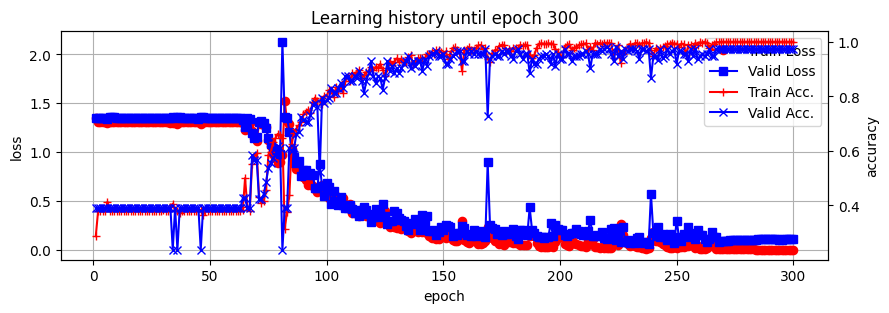

Epoch: 300, | T_Loss 0.001, | T_acc   1.0 | V_loss 0.108 | V_acc 0.973 | time  1.73
Epoch: 299, | T_Loss 0.001, | T_acc   1.0 | V_loss 0.111 | V_acc 0.973 | time  1.75
Epoch: 298, | T_Loss 0.001, | T_acc   1.0 | V_loss  0.11 | V_acc 0.973 | time  1.59
Epoch: 297, | T_Loss 0.001, | T_acc   1.0 | V_loss 0.108 | V_acc 0.973 | time  1.63
Epoch: 296, | T_Loss 0.001, | T_acc   1.0 | V_loss 0.107 | V_acc 0.973 | time  1.65
Epoch: 295, | T_Loss 0.001, | T_acc   1.0 | V_loss 0.103 | V_acc 0.973 | time  1.68
Epoch: 294, | T_Loss 0.001, | T_acc   1.0 | V_loss 0.104 | V_acc 0.973 | time  1.38
Epoch: 293, | T_Loss 0.001, | T_acc   1.0 | V_loss 0.105 | V_acc 0.973 | time  1.53
Epoch: 292, | T_Loss 0.001, | T_acc   1.0 | V_loss 0.104 | V_acc 0.973 | time  1.69
Epoch: 291, | T_Loss 0.001, | T_acc   1.0 | V_loss 0.106 | V_acc 0.973 | time  1.68
Epoch: 290, | T_Loss 0.001, | T_acc   1.0 | V_loss 0.105 | V_acc 0.973 | time  1.67
Epoch: 289, | T_Loss 0.001, | T_acc   1.0 | V_loss 0.106 | V_acc 0.973 | tim

In [12]:
# input_dim = len(dataset[0]['value'][0])
input_dim = 32
init_model(input_dim)
init_epoch()
init_log()
maximum_epoch = 300
min_eval_loss = 99999999 # loss 갱신 여부 탐색하기 위한 변수

def epoch_not_finished():
    return epoch_cnt < maximum_epoch

# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc = epoch(train_loader, mode = 'train')
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc = epoch(val_loader, mode = 'val')
        record_valid_log(vloss, vacc)
    print_log()
    
    # vloss가 작아질 때 마다 pt 파일 갱신
    if vloss < min_eval_loss:
        min_eval_loss = vloss
        torch.save(net, '../checkpoint/action_pt/best_action.pt')       
print('\n Training Completed')

In [14]:
# 정확도 검증
# 체크포인트 불러오기
net = torch.load('../checkpoint/action_pt/best_action.pt')
# net.load_state_dict(checkpoint['model'])
with torch.no_grad():
    test_loss, test_acc = epoch(test_loader, mode = 'test')
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc. : {}'.format(test_acc))
    print('Test Loss : {}'.format(test_loss))

Test Acc. : 0.9643
Test Loss : 0.2039


In [15]:
import cv2
interval = 1
length = 50
video_path = '../data/action_data/test_data/test_data_5.MOV'

cv2.destroyAllWindows()
cap = cv2.VideoCapture(video_path)
img_list = []

if cap.isOpened():
    cnt = 0
    while True:
        ret, img = cap.read()
        
        if ret:
            img = cv2.resize(img, (640, 640))
            if cnt == interval:
                img_list.append(img)
                cnt = 0
            # cv2.imshow(video_name, img)
            cv2.waitKey(1)
            cnt += 1
        else:
            break
cap.release()
cv2.destroyAllWindows()
print('저장된 frame의 개수 : {}'.format(len(img_list)))

저장된 frame의 개수 : 1368


In [16]:
box_annotator = sv.BoxAnnotator(
        thickness=2,
        text_thickness=2,
        text_scale=1)

model = YOLO('../checkpoint/yolo_pt/best.pt')

## 수정된 코드(아래 원본 코드 대신 이거 사용)

In [17]:
def get_hand_centers(results):
    # img = img_list[0]
    # pose = mp_pose.Pose(static_image_mode=True, model_complexity=1,
    #                     enable_segmentation = False, min_detection_confidence=0.3)

    # results = pose.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    rh_x_sum, rh_y_sum, lh_x_sum, lh_y_sum = 0, 0, 0, 0

    hand_centers = []

    for k in range(15, 23):
        if k == 15 or k == 17 or k == 19 or k == 21:
        # if k == 15:
            lh_x_sum += results.pose_landmarks.landmark[k].x
            lh_y_sum += results.pose_landmarks.landmark[k].y
        
        
        elif k == 16 or k == 18 or k == 20 or k == 22:
        # elif k == 16:
            rh_x_sum += results.pose_landmarks.landmark[k].x
            rh_y_sum += results.pose_landmarks.landmark[k].y
            
    lh_x_avg, lh_y_avg = lh_x_sum/4, lh_y_sum/4
    rh_x_avg, rh_y_avg = rh_x_sum/4, rh_y_sum/4     
        
    hand_centers.append([lh_x_avg, lh_y_avg])
    hand_centers.append([rh_x_avg, rh_y_avg])
    
    # print(hand_centers)
    return hand_centers

    

In [18]:
# 두 점 사이의 유클리디언 거리를 계산하는 함수
def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

### 테이블 영역의 xmin, ymin, xmax, ymax 좌표 확인

In [50]:
# Table의 xyxy 좌표를 확인해보자.
import cv2

img = img_list[0]
img = cv2.flip(img, 0)
img = cv2.flip(img, 1)

# 모델을 사용하여 YOLO 결과를 가져오는 부분입니다. 모델이 어떻게 정의되었는지에 따라 수정이 필요할 수 있습니다.
yolo_result = model(img, agnostic_nms=True)[0]

# YOLO 결과를 기반으로 Detections 객체를 만드는 부분입니다. 이 코드는 사용 중인 라이브러리에 따라 다를 수 있습니다.
detections = sv.Detections.from_yolov8(yolo_result)
selected_classes = [4]  # 4: table 
detections = detections[np.isin(detections.class_id, selected_classes)]
labels = [f"{model.model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
img = box_annotator.annotate(
                    scene=img, 
                    detections=detections, 
                    labels=labels)

for i in range(len(detections.xyxy)):
    point_1 = (detections.xyxy[i][0]/640, detections.xyxy[i][2]/640)
    point_2 = (detections.xyxy[i][1]/640, detections.xyxy[i][3]/640) 
print(point_1)
print(point_2)

cv2.imshow('Annotated Image', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 7765MiB)
YOLOv8m summary (fused): 218 layers, 25842655 parameters, 0 gradients, 78.7 GFLOPs


(0.125, 0.8578125)
(0.678125, 0.996875)


## Action 추론 및 시퀀스 저장

In [20]:
import json

net.eval()
out_img_list = []
dataset = []
status = ''
action = 0
fruit_type = 5
pose = mp_pose.Pose(static_image_mode=True, model_complexity=1,
                    enable_segmentation = False, min_detection_confidence=0.3)

print("시퀀스 데이터 분석 중...")

xy_list_list = []
# file_path = '../log/test5.json'
seq = {}
seq_index = 0

for img in tqdm(img_list):
    img = cv2.flip(img, 0)
    img = cv2.flip(img, 1)
    results = pose.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    if not results.pose_landmarks: continue
    test_dict = {}
    xy_list = []
    idx = 0
    person = 0
    
    fruit_quantity = 0
    draw_line_dic = {}
    
    yolo_result = model(img, agnostic_nms=True)[0]
    hand_centers = get_hand_centers(results)
    
    detections = sv.Detections.from_yolov8(yolo_result)
    # selected_classes = [0, 1, 2, 3, 4]  # 46: banana, 47 : apple, 49: orange 
    # detections = detections[np.isin(detections.class_id, selected_classes)]
    
    if 3 in detections.class_id:
        person = 1
        
    labels = [f"{model.model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
    
    
    object_centers = []
    class_ids = []
    
    # if len(detections.xyxy) == 0:
    #     detected_obj = [0.0, 0.0, 0.0, 0.0]
    # else:
    #     detected_obj = list(detections.xyxy[0] / 640)
    
    for i in range(len(detections.xyxy)):
        x_center = ((detections.xyxy[i][0] + detections.xyxy[i][2]) / 2) / 640
        y_center = ((detections.xyxy[i][1] + detections.xyxy[i][3]) / 2) / 640
        object_centers.append((x_center, y_center))
        class_ids.append(detections.class_id[i])
    
    
    min_distance = 100000
    holding_object = ''
    dist_list = []
    
    # 유클리디언 거리 계산 및 최소 거리와 해당 물체 이름 출력
    for i in range(len(detections.xyxy)):    
        
        # Holding left hand
        if hand_centers[0][1] <= 0.5 and object_centers[i][1] <= 0.8 and (class_ids[i] not in [3, 4]):
            distance = calculate_distance(object_centers[i], hand_centers[0])        
            if distance < min_distance:
                min_distance = distance
                fruit_type = class_ids[i]
                holding_object = model.model.names[class_ids[i]]
                fruit_quantity = 1
                
        # Holding right hand
        if hand_centers[1][1] <= 0.5 and object_centers[i][1] <= 0.8 and (class_ids[i] not in [3, 4]):
            distance = calculate_distance(object_centers[i], hand_centers[1])        
            if distance < min_distance:
                min_distance = distance
                fruit_type = class_ids[i]
                holding_object = model.model.names[class_ids[i]]
                fruit_quantity = 1
        
        # if hand_centers[0][1] <= 0.5 and object_centers[i][1] <= 0.8 and class_ids[i] not in [3, 4]:
        #         holding_object = model.model.names[class_ids[i]]
        
        
        # if hand_centers[1][1] <= 0.5 and object_centers[i][1] <= 0.8 and class_ids[i] not in [3, 4]:
        #         holding_object = model.model.names[class_ids[i]]
 
    min_distance = round(min_distance, 3)
    for x_and_y in results.pose_landmarks.landmark:
        if idx in attention_dot:
            xy_list.append(x_and_y.x)
            xy_list.append(x_and_y.y)
            x, y = int(x_and_y.x * 640), int(x_and_y.y * 640)
            draw_line_dic[idx] = [x, y]
        idx += 1
    
    if len(detections.xyxy) == 0:
        detected_obj = [0.0, 0.0, 0.0, 0.0]
    else:
        detected_obj = list(detections.xyxy[0] / 640)
    
    xy_list += detected_obj
    xy_list_list.append(xy_list)
    
    for line in draw_line:
        x1, y1 = draw_line_dic[line[0]][0], draw_line_dic[line[0]][1]
        x2, y2 = draw_line_dic[line[1]][0], draw_line_dic[line[1]][1]
        img = cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 4)

    img = box_annotator.annotate(
                    scene=img, 
                    detections=detections, 
                    labels=labels
                )
    if len(xy_list_list) == length:
        dataset = []
        dataset.append({'key' : 0, 'value' : xy_list_list})
        dataset = MyDataset(dataset)
        dataset = DataLoader(dataset)
        xy_list_list = []
        for data, label in dataset:
            data = data.to(device)
            with torch.no_grad():
                result = net(data)
                _, output = torch.max(result, 1)
                if output.item() == 0:
                    # status = f'Nothing {holding_object}, min_dist: {min_distance}'
                    status = 'Nothing' 
                    fruit_type = 5
                    action = 0

                elif output.item() == 1:  
                    status = 'Picking_up'
                    fruit_type = 5
                    action = 1
                    
                elif output.item() == 2:
                    status = 'Putting_down'
                    fruit_type = 5
                    action = 2
                elif output.item() == 3:
                    # if holding_object != '':
                    #     # status = f'Holding {holding_object}, min_dist: {min_distance}'
                    #     status = f'Holding {holding_object}'
                    # else: 
                    #     status = 'Holding'
                    
                    status = 'Holding ' + holding_object 
                    action = 3

    # 보정 완료: person, action, fruit_type, fruit_quantity
    test_dict['person'] = int(person)
    test_dict['action'] = int(action)
    test_dict['fruit_type'] = int(fruit_type)
    test_dict['fruit_quantity'] = int(fruit_quantity)
    # print(test_dict)
    
    # cv2.putText(img, status, (0, 50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 0, 255), 2)
    cv2.putText(img, f'{status}', (0, 25), cv2.FONT_HERSHEY_COMPLEX, 1.0, (0, 0, 0), 1)
    out_img_list.append(img)
    seq[seq_index] = test_dict
    seq_index += 1
    
with open('../log/action_5_log.json', 'w') as f:
     json.dump(seq, f, ensure_ascii=False, indent=4)

I0000 00:00:1702282628.443797   11516 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1702282628.444751   11828 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: AMD RENOIR (DRM 3.42.0, 5.15.0-89-generic, LLVM 12.0.0)


시퀀스 데이터 분석 중...


100%|██████████| 1368/1368 [01:51<00:00, 12.23it/s]


## 원본 코드

In [37]:
net.eval()
out_img_list = []
dataset = []
status = 'None'
pose = mp_pose.Pose(static_image_mode=True, model_complexity=1,
                    enable_segmentation = False, min_detection_confidence=0.3)

print("시퀀스 데이터 분석 중...")


xy_list_list = []
for img in tqdm(img_list):
    results = pose.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if not results.pose_landmarks: continue
    xy_list = []
    idx = 0
    draw_line_dic = {}
    
    yolo_result = model(img, agnostic_nms=True)[0]
    detections = sv.Detections.from_yolov8(yolo_result)
    
    selected_classes = [47]  # # 46: banana, 47 : apple, 49: orange 
    detections = detections[np.isin(detections.class_id, selected_classes)]
    
    labels = [f"{model.model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
    
    for x_and_y in results.pose_landmarks.landmark:
        if idx in attention_dot:
            xy_list.append(x_and_y.x)
            xy_list.append(x_and_y.y)
            x, y = int(x_and_y.x * 640), int(x_and_y.y * 640)
            draw_line_dic[idx] = [x, y]
        idx += 1
    
    if len(detections.xyxy) == 0:
        detected_obj = [0.0, 0.0, 0.0, 0.0]
    else:
        detected_obj = list(detections.xyxy[0] / 640)
    
    xy_list += detected_obj
    
    xy_list_list.append(xy_list)
    
    for line in draw_line:
        x1, y1 = draw_line_dic[line[0]][0], draw_line_dic[line[0]][1]
        x2, y2 = draw_line_dic[line[1]][0], draw_line_dic[line[1]][1]
        img = cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 4)

    img = box_annotator.annotate(
                    scene=img, 
                    detections=detections, 
                    labels=labels
                )
    if len(xy_list_list) == length:
        dataset = []
        dataset.append({'key' : 0, 'value' : xy_list_list})
        dataset = MyDataset(dataset)
        dataset = DataLoader(dataset)
        xy_list_list = []
        for data, label in dataset:
            data = data.to(device)
            with torch.no_grad():
                result = net(data)
                _, out = torch.max(result, 1)
                if out.item() == 0:
                    status = 'Nothing'
                elif out.item() == 1: 
                    status = 'Picking'
                else:
                    status = 'Holding'
    
    cv2.putText(img, status, (0, 50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 0, 255), 2)
    out_img_list.append(img)

I0000 00:00:1701060241.301410   14070 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


시퀀스 데이터 분석 중...


I0000 00:00:1701060241.302118   15093 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.0.4-0ubuntu1~22.04.1), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
  0%|          | 1/1028 [00:00<01:54,  8.96it/s]
0: 640x640 1 person, 1 tie, 1 dining table, 29.7ms
Speed: 0.6ms pre-process, 29.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 3 apples, 1 toothbrush, 29.9ms
Speed: 0.5ms pre-process, 29.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
  0%|          | 3/1028 [00:00<01:33, 11.01it/s]
0: 640x640 1 person, 1 tie, 3 apples, 29.5ms
Speed: 0.5ms pre-process, 29.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
  1%|          | 6/1028 [00:00<01:10, 14.44it/s]
0: 640x640 1 person, 3 apples, 1 dining table, 29.6ms
Speed: 0.5ms pre-process, 29.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 persons, 3 apples, 1 dining table, 29.6ms
Speed: 0.6ms pre-process, 29.6ms inf

## 테스트 결과 영상 저장

In [21]:
filename = '../results/test_5_result.mp4'
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
fps = 30
frameSize = (640, 640)
isColor = True
out = cv2.VideoWriter(filename, fourcc, fps, frameSize, isColor)
for out_img in out_img_list:
    out.write(out_img)
out.release()

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


## Real-time 동작

In [22]:
import json
import cv2 

net.eval()
out_img_list = []
dataset = []
status = ''
action = 0
fruit_type = 5
pose = mp_pose.Pose(static_image_mode=True, model_complexity=1,
                    enable_segmentation = False, min_detection_confidence=0.3)

print("시퀀스 데이터 분석 중...")

xy_list_list = []
# file_path = '../log/test5.json'
seq = {}
seq_index = 0
            
img = cv2.flip(img, 0)
img = cv2.flip(img, 1)
results = pose.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

if not results.pose_landmarks: continue
test_dict = {}
xy_list = []
idx = 0
person = 0

fruit_quantity = 0
draw_line_dic = {}

yolo_result = model(img, agnostic_nms=True)[0]
hand_centers = get_hand_centers(results)

detections = sv.Detections.from_yolov8(yolo_result)
# selected_classes = [0, 1, 2, 3, 4]  # 46: banana, 47 : apple, 49: orange 
# detections = detections[np.isin(detections.class_id, selected_classes)]

if 3 in detections.class_id:
    person = 1
    
labels = [f"{model.model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]


object_centers = []
class_ids = []

# if len(detections.xyxy) == 0:
#     detected_obj = [0.0, 0.0, 0.0, 0.0]
# else:
#     detected_obj = list(detections.xyxy[0] / 640)

for i in range(len(detections.xyxy)):
    x_center = ((detections.xyxy[i][0] + detections.xyxy[i][2]) / 2) / 640
    y_center = ((detections.xyxy[i][1] + detections.xyxy[i][3]) / 2) / 640
    object_centers.append((x_center, y_center))
    class_ids.append(detections.class_id[i])


min_distance = 100000
holding_object = ''
dist_list = []

# 유클리디언 거리 계산 및 최소 거리와 해당 물체 이름 출력
for i in range(len(detections.xyxy)):    
    
    # Holding left hand
    if hand_centers[0][1] <= 0.5 and object_centers[i][1] <= 0.8 and (class_ids[i] not in [3, 4]):
        distance = calculate_distance(object_centers[i], hand_centers[0])        
        if distance < min_distance:
            min_distance = distance
            fruit_type = class_ids[i]
            holding_object = model.model.names[class_ids[i]]
            fruit_quantity = 1
            
    # Holding right hand
    if hand_centers[1][1] <= 0.5 and object_centers[i][1] <= 0.8 and (class_ids[i] not in [3, 4]):
        distance = calculate_distance(object_centers[i], hand_centers[1])        
        if distance < min_distance:
            min_distance = distance
            fruit_type = class_ids[i]
            holding_object = model.model.names[class_ids[i]]
            fruit_quantity = 1
    
    # if hand_centers[0][1] <= 0.5 and object_centers[i][1] <= 0.8 and class_ids[i] not in [3, 4]:
    #         holding_object = model.model.names[class_ids[i]]
    
    
    # if hand_centers[1][1] <= 0.5 and object_centers[i][1] <= 0.8 and class_ids[i] not in [3, 4]:
    #         holding_object = model.model.names[class_ids[i]]

min_distance = round(min_distance, 3)
for x_and_y in results.pose_landmarks.landmark:
    if idx in attention_dot:
        xy_list.append(x_and_y.x)
        xy_list.append(x_and_y.y)
        x, y = int(x_and_y.x * 640), int(x_and_y.y * 640)
        draw_line_dic[idx] = [x, y]
    idx += 1

if len(detections.xyxy) == 0:
    detected_obj = [0.0, 0.0, 0.0, 0.0]
else:
    detected_obj = list(detections.xyxy[0] / 640)

xy_list += detected_obj
xy_list_list.append(xy_list)

for line in draw_line:
    x1, y1 = draw_line_dic[line[0]][0], draw_line_dic[line[0]][1]
    x2, y2 = draw_line_dic[line[1]][0], draw_line_dic[line[1]][1]
    img = cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 4)

img = box_annotator.annotate(
                scene=img, 
                detections=detections, 
                labels=labels
            )
if len(xy_list_list) == length:
    dataset = []
    dataset.append({'key' : 0, 'value' : xy_list_list})
    dataset = MyDataset(dataset)
    dataset = DataLoader(dataset)
    xy_list_list = []
    for data, label in dataset:
        data = data.to(device)
        with torch.no_grad():
            result = net(data)
            _, output = torch.max(result, 1)
            if output.item() == 0:
                # status = f'Nothing {holding_object}, min_dist: {min_distance}'
                status = 'Nothing' 
                fruit_type = 5
                action = 0

            elif output.item() == 1:  
                status = 'Picking_up'
                fruit_type = 5
                action = 1
                
            elif output.item() == 2:
                status = 'Putting_down'
                fruit_type = 5
                action = 2
            elif output.item() == 3:
                # if holding_object != '':
                #     # status = f'Holding {holding_object}, min_dist: {min_distance}'
                #     status = f'Holding {holding_object}'
                # else: 
                #     status = 'Holding'
                
                status = 'Holding ' + holding_object 
                action = 3

# 보정 완료: person, action, fruit_type, fruit_quantity
test_dict['person'] = int(person)
test_dict['action'] = int(action)
test_dict['fruit_type'] = int(fruit_type)
test_dict['fruit_quantity'] = int(fruit_quantity)
# print(test_dict)

# cv2.putText(img, status, (0, 50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 0, 255), 2)
cv2.putText(img, f'{status}', (0, 25), cv2.FONT_HERSHEY_COMPLEX, 1.0, (0, 0, 0), 1)
out_img_list.append(img)
seq[seq_index] = test_dict
seq_index += 1
    
with open('../log/action_5_log.json', 'w') as f:
     json.dump(seq, f, ensure_ascii=False, indent=4)

IndentationError: expected an indented block (2713171604.py, line 29)